In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

<b> Question 1: <u>Modeling volatility Find data for historical prices for any publicly traded equity. </u></b>

To ensure the length of data, use daily data for at least 3 years. Fit the historical data to

1. Geometric Brownian motion
2. Any non-constant volatility model

Find market data for option prices for this stock. Use option prices to

3. Show volatility smile
4. Construct term structure of volatility
5. Plot the volatility surface, as a function of time to maturity and moneyness.

In [2]:
spy = yf.Ticker('SPY')
df = spy.history(period="5y")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-10-04 00:00:00-04:00,422.070007,425.429993,420.559998,424.660004,87453000,0.0,0.0,0.0
2023-10-05 00:00:00-04:00,424.359985,425.369995,421.170013,424.500000,70142700,0.0,0.0,0.0
2023-10-06 00:00:00-04:00,421.970001,431.130005,420.600006,429.540009,113202700,0.0,0.0,0.0
2023-10-09 00:00:00-04:00,427.579987,432.880005,427.010010,432.290009,80374400,0.0,0.0,0.0
2023-10-10 00:00:00-04:00,432.940002,437.220001,432.529999,434.540009,78539100,0.0,0.0,0.0


<b> 1. <u>Geometric Brownian motion </b>

$\frac{lnS(t_i)-lnS(t_{i-1})}{\sqrt{\Delta t}}= (\mu-\frac{1}{2}\sigma^2)\sqrt{\Delta t}+\sigma\frac{B(t_i)-B(t_{i-1})}{\sqrt{\Delta t}}$

In [3]:
y = np.log(df.Close/df.Close.shift(1))*np.sqrt(252)

In [4]:
#historic volatility
hv = y.std()
hv

0.21530559783531628

$ s^2 = \frac{1}{N-1} (\sum_{i=1}^{N}y_i^2-N\overline{y}^2)  $

In [5]:
np.sqrt(((y**2).sum()-len(y)*y.mean()**2)/(len(y)-1))

0.21521978013123275

<b> 2. <u>Any non-constant volatility model</u></b>

a. Rolling 20d historic volatility

Text(0, 0.5, 'volatility')

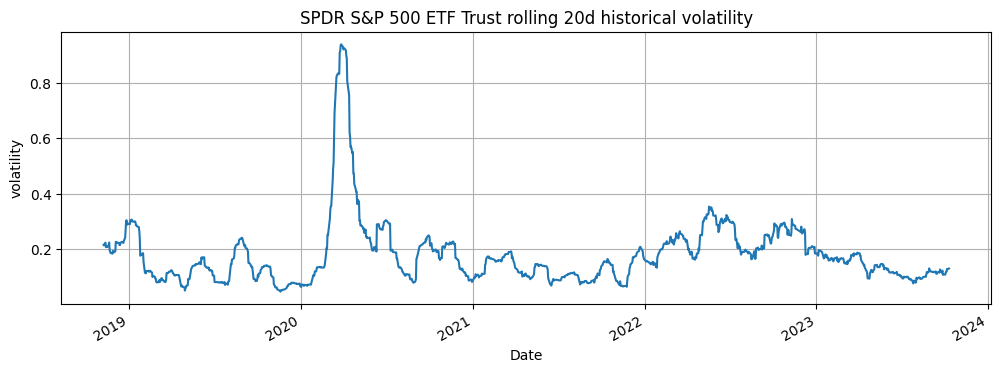

In [6]:
# rolling 20d historic volatility
ax = (y.rolling(20).std()).plot(figsize=(12,4),grid=True,title=spy.info['longName']+' rolling 20d historical volatility')
ax.set_ylabel('volatility')

b. EWMA volatility model

In [7]:
#EWMA volatility model
vol0 = y[:21].std()
decay = 0.9
ewma_vol = pd.Series(index=y.index)
for i in range(22, len(y.index)):
    ewma_vol.iloc[i] = (1-decay)*y.iloc[i-1]**2 + decay*vol0**2
    vol0 =  ewma_vol.iloc[i]
ewma_vol = np.sqrt(ewma_vol)


Text(0, 0.5, 'volatility')

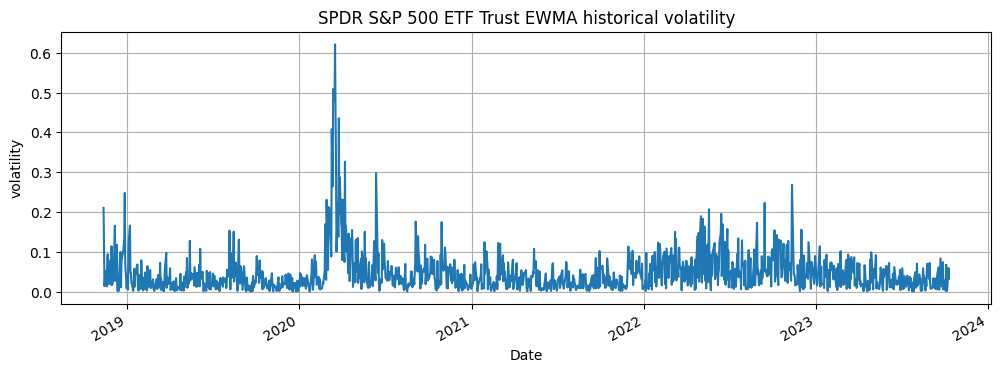

In [8]:
ax = ewma_vol.plot(figsize=(12,4),grid=True,title=spy.info['longName']+' EWMA historical volatility')
ax.set_ylabel('volatility')

c. GARCH Model

$y_i=\frac{lnS(t_i)-lnS(t_{i-1})-(\mu-\frac{1}{2}\sigma_i^2)\Delta t}{\sqrt{\Delta t}} \quad \text{follows} \quad N(0,\sigma_i^2)$

$\sigma_{i+1}^2=\kappa\theta+(1-\kappa)[(1-\lambda)y_i^2+\lambda\sigma_i^2]$

In [9]:
kappa = 0.01
theta = 0.04
dacay = 0.9

In [10]:
#EWMA volatility model
vol0 = y[:21].std()
garch_vol = pd.Series(index=y.index)
for i in range(22, len(y.index)):
    garch_vol.iloc[i] = kappa*theta+(1-kappa)*((1-decay)*y.iloc[i-1]**2 + decay*vol0**2)
    vol0 =  garch_vol.iloc[i]
garch_vol = np.sqrt(garch_vol)


Text(0, 0.5, 'volatility')

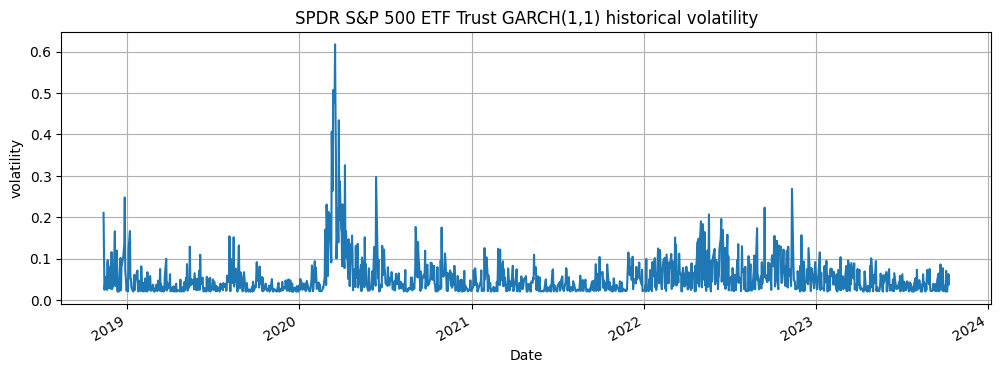

In [11]:
ax = garch_vol.plot(figsize=(12,4),grid=True,title=spy.info['longName']+' GARCH(1,1) historical volatility')
ax.set_ylabel('volatility')

<b> 3. <u>Show volatility smile </u></b>

In [195]:
tk = yf.Ticker("SPY")
# Expiration dates
exps = tk.options
# Get options for each expiration
options = pd.DataFrame()
for e in exps:
    opt = tk.option_chain(e)
    opt.calls['optionType'] = 'Call'
    opt.puts['optionType'] = 'Put'
    opt.calls['expirationDate'] = e
    opt.puts['expirationDate'] = e
    
    options = pd.concat([options, pd.concat([opt.calls, opt.puts])])
    

In [196]:
spot = tk.history()["Close"].iloc[-1]

In [197]:
options["Moneyness"] = round(options["strike"]/spot,2)
options = options.set_index("Moneyness")

In [198]:
iv_surface = pd.DataFrame()
for t in exps:
    ivc = options[(options["expirationDate"] == t) & (options["inTheMoney"] == False)].sort_values("strike")["impliedVolatility"]
    adj_ivc = ivc.groupby("Moneyness").mean()
    adj_ivc.name = t
    iv_surface = pd.concat([iv_surface, adj_ivc], axis = 1)

In [199]:
iv_surface.columns = pd.to_datetime(iv_surface.columns)
iv_surface = iv_surface.sort_index()
iv_surface = iv_surface.interpolate(limit_area="inside")

In [200]:
thirdW5 = pd.date_range(exps[0], exps[-1], freq="WOM-3FRI")
thirdW5 = iv_surface.columns.intersection(thirdW5)

Text(0.5, 1.0, 'IV Curve of SPDR S&P 500 ETF Trust')

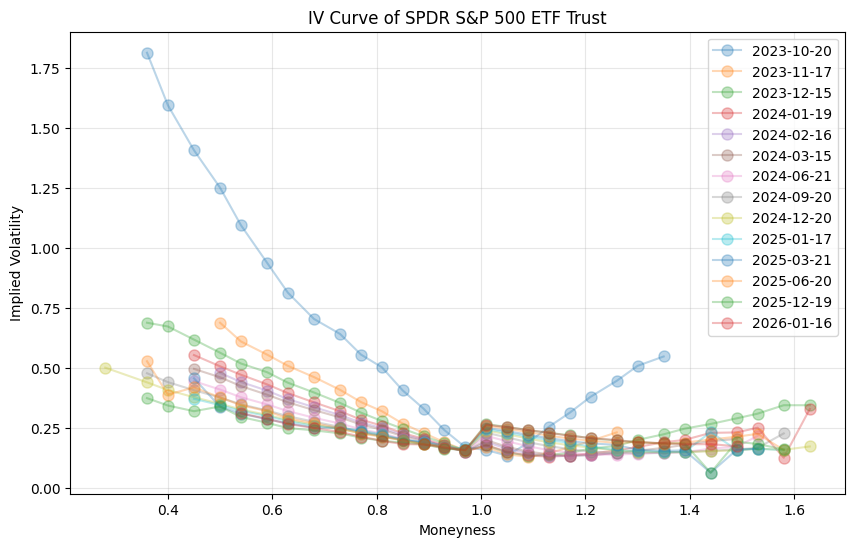

In [201]:
ax = iv_surface.loc[::4,thirdW5].plot(figsize=(10,6), style='-o', alpha = 0.3, ms=8)
ax.grid(alpha = 0.3)
ax.legend(thirdW5.strftime("%Y-%m-%d"))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Implied Volatility")
ax.set_title('IV Curve of '+tk.info['longName'])

<b> 4. <u>Construct term structure of volatility</u></b>

Text(0.5, 1.0, 'IV Term Structure of SPDR S&P 500 ETF Trust')

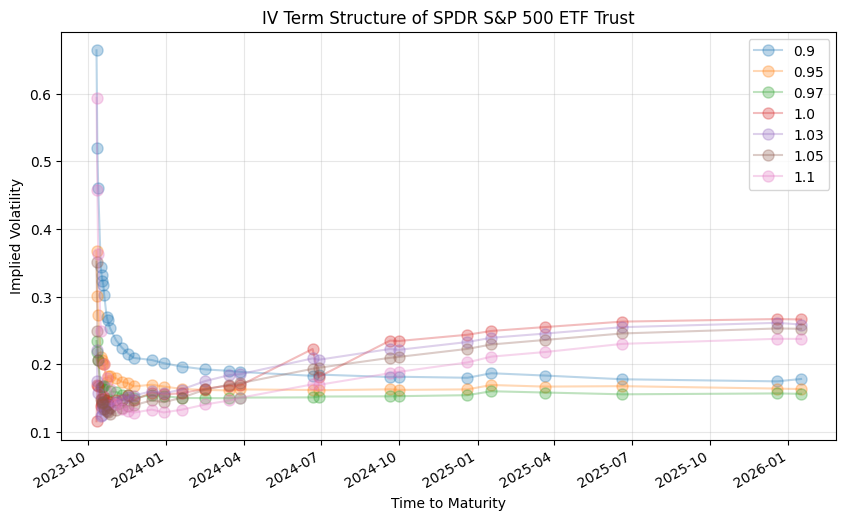

In [202]:
ax = iv_surface.transpose()[[0.9,0.95,0.97,1,1.03,1.05,1.1]].plot(figsize=(10,6), style='-o', alpha = 0.3, ms=8)
ax.grid(alpha = 0.3)
ax.set_xlabel("Time to Maturity")
ax.set_ylabel("Implied Volatility")
ax.set_title('IV Term Structure of '+tk.info['longName'])

<b> 5. <u>Plot the volatility surface, as a function of time to maturity and moneyness.</u></b>

In [203]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [212]:
#Singapore time is ahead 1 day to the US time
time2maturity = [((i - datetime.today()).days + 1) / 365 for i in iv_surface[thirdW5].columns]

Text(0.5, 0.92, 'IV Surface of SPDR S&P 500 ETF Trust')

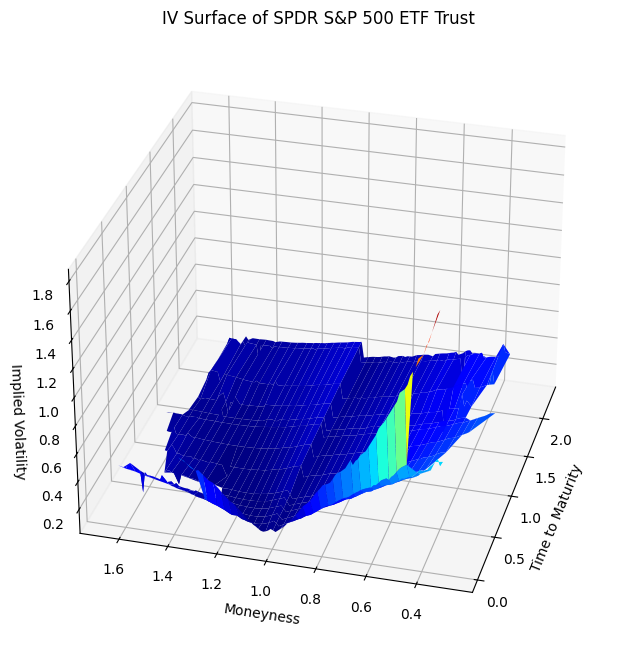

In [245]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(time2maturity, iv_surface[thirdW5].index)
ax.plot_surface(X, Y, iv_surface[thirdW5], cmap=cm.jet, linewidth=0.2)
ax.view_init(30, -165) 
ax.set_xlabel("Time to Maturity")
ax.set_ylabel("Moneyness")
ax.set_zlabel("Implied Volatility")
ax.set_title('IV Surface of '+tk.info['longName'])